# Linear Regression Consulting Project

Congratulations! You've been contracted by Hyundai Heavy Industries to help them build a predictive model for some ships. [Hyundai Heavy Industries](http://www.hyundai.eu/en) is one of the world's largest ship manufacturing companies and builds cruise liners.

You've been flown to their headquarters in Ulsan, South Korea to help them give accurate estimates of how many crew members a ship will require.

They are currently building new ships for some customers and want you to create a model and use it to predict how many crew members the ships will need.

Here is what the data looks like so far:

    Description: Measurements of ship size, capacity, crew, and age for 158 cruise
    ships.


    Variables/Columns
    Ship Name     1-20
    Cruise Line   21-40
    Age (as of 2013)   46-48
    Tonnage (1000s of tons)   50-56
    passengers (100s)   58-64
    Length (100s of feet)  66-72
    Cabins  (100s)   74-80
    Passenger Density   82-88
    Crew  (100s)   90-96
    
It is saved in a csv file for you called "cruise_ship_info.csv". Your job is to create a regression model that will help predict how many crew members will be needed for future ships. The client also mentioned that they have found that particular cruise lines will differ in acceptable crew counts, so it is most likely an important feature to include in your analysis! 

Once you've created the model and tested it for a quick check on how well you can expect it to perform, make sure you take a look at why it performs so well!

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('lr_ship').getOrCreate()

In [2]:
df = spark.read.csv('../datasets/cruise_ship_info.csv', inferSchema=True, header=True)

In [3]:
df.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



In [5]:
df.show()

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36|10.0|
|    Ecstasy|   Carnival| 22|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|
|    Elation|   Carnival| 15|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|
|    Fantasy|   Carnival| 23| 

In [6]:
df.head(1)

[Row(Ship_name='Journey', Cruise_line='Azamara', Age=6, Tonnage=30.276999999999997, passengers=6.94, length=5.94, cabins=3.55, passenger_density=42.64, crew=3.55)]

In [8]:
df.describe().show()

+-------+---------+-----------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+
|summary|Ship_name|Cruise_line|               Age|           Tonnage|       passengers|           length|            cabins|passenger_density|             crew|
+-------+---------+-----------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+
|  count|      158|        158|               158|               158|              158|              158|               158|              158|              158|
|   mean| Infinity|       null|15.689873417721518| 71.28467088607599|18.45740506329114|8.130632911392404| 8.830000000000005|39.90094936708861|7.794177215189873|
| stddev|      NaN|       null| 7.615691058751413|37.229540025907866|9.677094775143416|1.793473548054825|4.4714172221480615| 8.63921711391542|3.503486564627034|
|    min|Adventure|    Azamara|   

In [10]:
df.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



In [11]:
from pyspark.sql.functions import format_number

In [16]:
result = df.describe()
new_describe = result.select(result['summary'],
                             result['Ship_name'],
                             result['Age'].cast('int').alias('Age'),
                             format_number(result['Tonnage'].cast('double'), 2).alias('Tonnage'),
                             format_number(result['passengers'].cast('double'), 2).alias('passengers'),
                             format_number(result['length'].cast('double'), 2).alias('length'),
                             format_number(result['cabins'].cast('double'), 2).alias('cabins'),
                             format_number(result['passenger_density'].cast('double'), 2).alias('p_density'),
                             format_number(result['crew'].cast('double'), 2).alias('crew'))

In [17]:
new_describe.show()

+-------+---------+---+-------+----------+------+------+---------+------+
|summary|Ship_name|Age|Tonnage|passengers|length|cabins|p_density|  crew|
+-------+---------+---+-------+----------+------+------+---------+------+
|  count|      158|158| 158.00|    158.00|158.00|158.00|   158.00|158.00|
|   mean| Infinity| 15|  71.28|     18.46|  8.13|  8.83|    39.90|  7.79|
| stddev|      NaN|  7|  37.23|      9.68|  1.79|  4.47|     8.64|  3.50|
|    min|Adventure|  4|   2.33|      0.66|  2.79|  0.33|    17.70|  0.59|
|    max|Zuiderdam| 48| 220.00|     54.00| 11.82| 27.00|    71.43| 21.00|
+-------+---------+---+-------+----------+------+------+---------+------+



In [18]:
df.count()

158

## EDA with pandas and visualization

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')
sns.set_palette('summer')

In [21]:
eda = pd.read_csv('../datasets/cruise_ship_info.csv')
eda.head()

,Ship_name,Cruise_line,Age,Tonnage,passengers,length,cabins,passenger_density,crew
0,Journey,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
1,Quest,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
2,Celebration,Carnival,26,47.262,14.86,7.22,7.43,31.80,6.70
3,Conquest,Carnival,11,110.000,29.74,9.53,14.88,36.99,19.10
4,Destiny,Carnival,17,101.353,26.42,8.92,13.21,38.36,10.00


In [22]:
eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ship_name          158 non-null    object 
 1   Cruise_line        158 non-null    object 
 2   Age                158 non-null    int64  
 3   Tonnage            158 non-null    float64
 4   passengers         158 non-null    float64
 5   length             158 non-null    float64
 6   cabins             158 non-null    float64
 7   passenger_density  158 non-null    float64
 8   crew               158 non-null    float64
dtypes: float64(6), int64(1), object(2)
memory usage: 11.2+ KB


In [24]:
eda['Ship_name'].value_counts()

Spirit        4
Legend        3
Star          3
Dawn          2
Rhapsody      2
             ..
Conquest      1
Magica        1
Brilliance    1
Armonia       1
Surf          1
Name: Ship_name, Length: 138, dtype: int64

In [25]:
eda['Cruise_line'].value_counts()

Royal_Caribbean      23
Carnival             22
Princess             17
Holland_American     14
Norwegian            13
Costa                11
Celebrity            10
MSC                   8
Star                  6
P&O                   6
Regent_Seven_Seas     5
Silversea             4
Cunard                3
Seabourn              3
Oceania               3
Windstar              3
Disney                2
Azamara               2
Crystal               2
Orient                1
Name: Cruise_line, dtype: int64

`Ship_name` is kinda useless but `Cruise_line` can be used for the model. Need to convert into categorical.

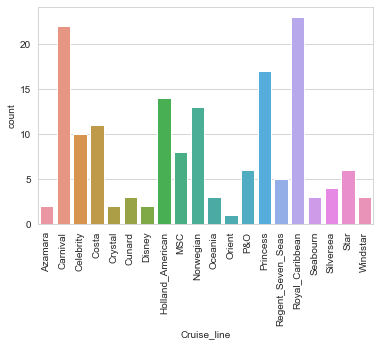

In [30]:
sns.countplot(x='Cruise_line', data=eda)
plt.xticks(rotation=90);

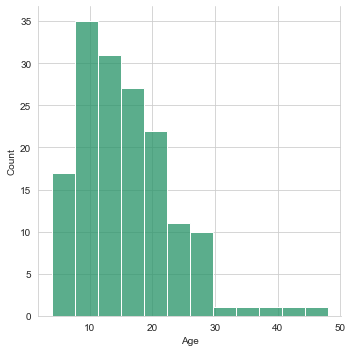

In [32]:
sns.displot(x='Age', data=eda)

<AxesSubplot:xlabel='Age', ylabel='crew'>

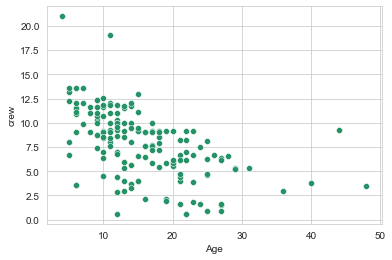

In [33]:
sns.scatterplot(x='Age', y='crew', data=eda)

In [34]:
eda.isna().sum()

Ship_name            0
Cruise_line          0
Age                  0
Tonnage              0
passengers           0
length               0
cabins               0
passenger_density    0
crew                 0
dtype: int64

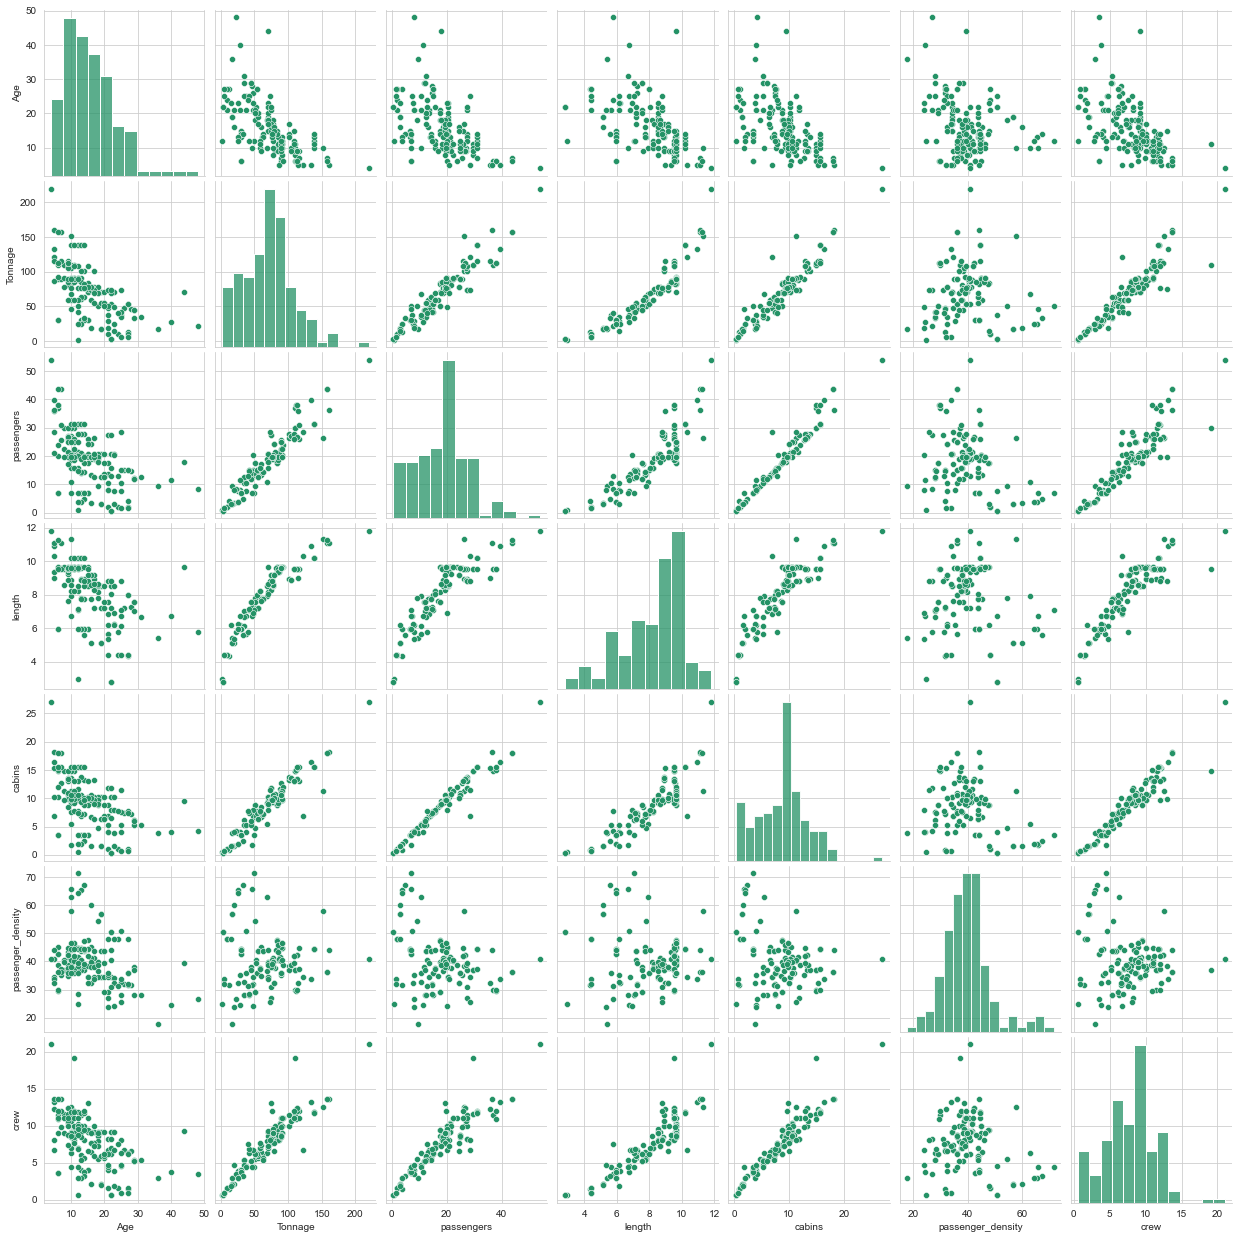

In [36]:
sns.pairplot(eda)

<AxesSubplot:xlabel='cabins', ylabel='crew'>

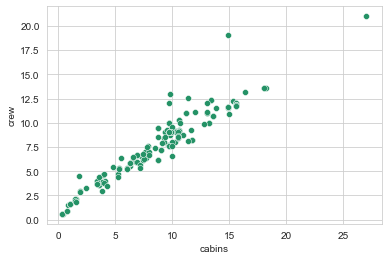

In [37]:
sns.scatterplot(x='cabins', y='crew', data=eda)

In [38]:
eda.corr()

,Age,Tonnage,passengers,length,cabins,passenger_density,crew
Age,1.000000,-0.606646,-0.515542,-0.532286,-0.510019,-0.278830,-0.530657
Tonnage,-0.606646,1.000000,0.945061,0.922368,0.948764,-0.040846,0.927569
passengers,-0.515542,0.945061,1.000000,0.883535,0.976341,-0.294867,0.915234
length,-0.532286,0.922368,0.883535,1.000000,0.889798,-0.090488,0.895857
cabins,-0.510019,0.948764,0.976341,0.889798,1.000000,-0.253181,0.950823
passenger_density,-0.278830,-0.040846,-0.294867,-0.090488,-0.253181,1.000000,-0.155509
crew,-0.530657,0.927569,0.915234,0.895857,0.950823,-0.155509,1.000000


<AxesSubplot:>

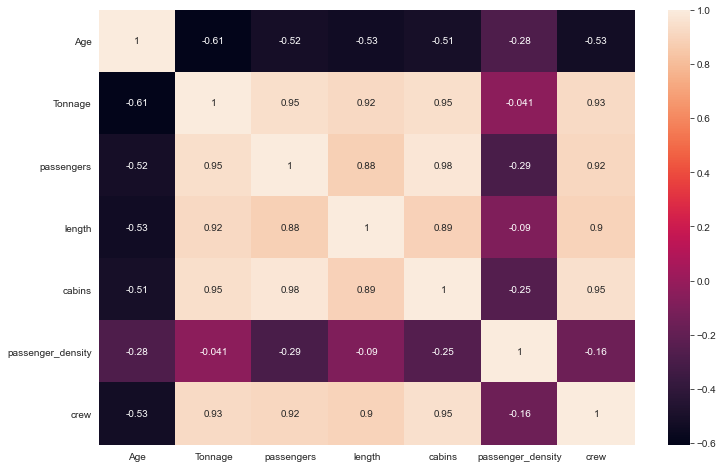

In [45]:
plt.figure(figsize=(12, 8))
sns.heatmap(eda.corr(), annot=True)

`Age` and `passenger_density` have the least correlations with `crew`

## Back to spark

In [46]:
df.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



**Dealing with `Cruise_line`**

In [51]:
df.groupBy('Cruise_line').count().show()

+-----------------+-----+
|      Cruise_line|count|
+-----------------+-----+
|            Costa|   11|
|              P&O|    6|
|           Cunard|    3|
|Regent_Seven_Seas|    5|
|              MSC|    8|
|         Carnival|   22|
|          Crystal|    2|
|           Orient|    1|
|         Princess|   17|
|        Silversea|    4|
|         Seabourn|    3|
| Holland_American|   14|
|         Windstar|    3|
|           Disney|    2|
|        Norwegian|   13|
|          Oceania|    3|
|          Azamara|    2|
|        Celebrity|   10|
|             Star|    6|
|  Royal_Caribbean|   23|
+-----------------+-----+



In [52]:
from pyspark.ml.feature import StringIndexer

In [53]:
indexer = StringIndexer(inputCol='Cruise_line', outputCol='cruise_cat')

In [57]:
indexed = indexer.fit(df).transform(df)

In [58]:
indexed.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)
 |-- cruise_cat: double (nullable = false)



In [59]:
indexed.groupBy('cruise_cat').count().show()

+----------+-----+
|cruise_cat|count|
+----------+-----+
|       8.0|    6|
|       0.0|   23|
|       7.0|    8|
|      18.0|    2|
|       1.0|   22|
|       4.0|   13|
|      11.0|    4|
|      14.0|    3|
|       3.0|   14|
|      19.0|    1|
|       2.0|   17|
|      17.0|    2|
|      10.0|    5|
|      13.0|    3|
|       6.0|   10|
|       5.0|   11|
|      15.0|    3|
|       9.0|    6|
|      16.0|    2|
|      12.0|    3|
+----------+-----+



**Split into feature and label**

In [47]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [61]:
indexed.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)
 |-- cruise_cat: double (nullable = false)



In [60]:
indexed.columns

['Ship_name',
 'Cruise_line',
 'Age',
 'Tonnage',
 'passengers',
 'length',
 'cabins',
 'passenger_density',
 'crew',
 'cruise_cat']

In [62]:
assembler = VectorAssembler(inputCols=['Age',
                                       'Tonnage',
                                       'passengers',
                                       'length',
                                       'cabins',
                                       'passenger_density',
                                       'cruise_cat'],
                            outputCol='features')

In [63]:
output = assembler.transform(indexed)

In [64]:
output.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)
 |-- cruise_cat: double (nullable = false)
 |-- features: vector (nullable = true)



In [65]:
output.select('features').show()

+--------------------+
|            features|
+--------------------+
|[6.0,30.276999999...|
|[6.0,30.276999999...|
|[26.0,47.262,14.8...|
|[11.0,110.0,29.74...|
|[17.0,101.353,26....|
|[22.0,70.367,20.5...|
|[15.0,70.367,20.5...|
|[23.0,70.367,20.5...|
|[19.0,70.367,20.5...|
|[6.0,110.23899999...|
|[10.0,110.0,29.74...|
|[28.0,46.052,14.5...|
|[18.0,70.367,20.5...|
|[17.0,70.367,20.5...|
|[11.0,86.0,21.24,...|
|[8.0,110.0,29.74,...|
|[9.0,88.5,21.24,9...|
|[15.0,70.367,20.5...|
|[12.0,88.5,21.24,...|
|[20.0,70.367,20.5...|
+--------------------+
only showing top 20 rows



In [66]:
output.select('features').head(1)

[Row(features=DenseVector([6.0, 30.277, 6.94, 5.94, 3.55, 42.64, 16.0]))]

In [69]:
final_data = output.select(['features', 'crew'])

In [70]:
final_data.show()

+--------------------+----+
|            features|crew|
+--------------------+----+
|[6.0,30.276999999...|3.55|
|[6.0,30.276999999...|3.55|
|[26.0,47.262,14.8...| 6.7|
|[11.0,110.0,29.74...|19.1|
|[17.0,101.353,26....|10.0|
|[22.0,70.367,20.5...| 9.2|
|[15.0,70.367,20.5...| 9.2|
|[23.0,70.367,20.5...| 9.2|
|[19.0,70.367,20.5...| 9.2|
|[6.0,110.23899999...|11.5|
|[10.0,110.0,29.74...|11.6|
|[28.0,46.052,14.5...| 6.6|
|[18.0,70.367,20.5...| 9.2|
|[17.0,70.367,20.5...| 9.2|
|[11.0,86.0,21.24,...| 9.3|
|[8.0,110.0,29.74,...|11.6|
|[9.0,88.5,21.24,9...|10.3|
|[15.0,70.367,20.5...| 9.2|
|[12.0,88.5,21.24,...| 9.3|
|[20.0,70.367,20.5...| 9.2|
+--------------------+----+
only showing top 20 rows



**Split into train and test**

In [71]:
train, test = final_data.randomSplit([0.7, 0.3])
train.count(), test.count()

(107, 51)

## Linear Regression model

In [72]:
from pyspark.ml.regression import LinearRegression

In [73]:
lr = LinearRegression(featuresCol='features', labelCol='crew')

In [74]:
lr_model = lr.fit(train)

In [75]:
results = lr_model.evaluate(test)

In [78]:
results.meanAbsoluteError

0.5274409403704466

In [79]:
results.meanSquaredError

0.4558529535022548

In [80]:
results.rootMeanSquaredError

0.6751688333315267

In [81]:
results.r2

0.9576619013838092

In [87]:
final_data.describe().show()

+-------+-----------------+
|summary|             crew|
+-------+-----------------+
|  count|              158|
|   mean|7.794177215189873|
| stddev|3.503486564627034|
|    min|             0.59|
|    max|             21.0|
+-------+-----------------+



**Test with unlabeled data**

In [89]:
test.show()

+--------------------+-----+
|            features| crew|
+--------------------+-----+
|[5.0,86.0,21.04,9...|  8.0|
|[5.0,115.0,35.74,...| 12.2|
|[5.0,133.5,39.59,...|13.13|
|[5.0,160.0,36.34,...| 13.6|
|[6.0,30.276999999...| 3.55|
|[6.0,90.0,20.0,9....|  9.0|
|[6.0,93.0,23.94,9...|11.09|
|[6.0,112.0,38.0,9...| 10.9|
|[8.0,91.0,22.44,9...| 11.0|
|[8.0,110.0,29.74,...| 11.6|
|[9.0,105.0,27.2,8...|10.68|
|[10.0,81.76899999...| 8.42|
|[10.0,86.0,21.14,...|  9.2|
|[10.0,138.0,31.14...|11.85|
|[11.0,91.0,20.32,...| 9.99|
|[11.0,108.977,26....| 12.0|
|[12.0,77.104,20.0...| 9.59|
|[13.0,25.0,3.82,5...| 2.95|
|[13.0,61.0,13.8,7...|  6.0|
|[13.0,76.0,18.74,...|  8.5|
+--------------------+-----+
only showing top 20 rows



In [90]:
test.count()

51

In [92]:
unlabeled_data = test.select('features')
unlabeled_data.show()

+--------------------+
|            features|
+--------------------+
|[5.0,86.0,21.04,9...|
|[5.0,115.0,35.74,...|
|[5.0,133.5,39.59,...|
|[5.0,160.0,36.34,...|
|[6.0,30.276999999...|
|[6.0,90.0,20.0,9....|
|[6.0,93.0,23.94,9...|
|[6.0,112.0,38.0,9...|
|[8.0,91.0,22.44,9...|
|[8.0,110.0,29.74,...|
|[9.0,105.0,27.2,8...|
|[10.0,81.76899999...|
|[10.0,86.0,21.14,...|
|[10.0,138.0,31.14...|
|[11.0,91.0,20.32,...|
|[11.0,108.977,26....|
|[12.0,77.104,20.0...|
|[13.0,25.0,3.82,5...|
|[13.0,61.0,13.8,7...|
|[13.0,76.0,18.74,...|
+--------------------+
only showing top 20 rows



In [93]:
predictions = lr_model.transform(unlabeled_data)

In [94]:
predictions.show()

+--------------------+------------------+
|            features|        prediction|
+--------------------+------------------+
|[5.0,86.0,21.04,9...| 9.455048444611885|
|[5.0,115.0,35.74,...|  11.9736138642863|
|[5.0,133.5,39.59,...|13.285045342999986|
|[5.0,160.0,36.34,...| 15.22341841674297|
|[6.0,30.276999999...|   4.5658629815147|
|[6.0,90.0,20.0,9....|10.330299191858552|
|[6.0,93.0,23.94,9...|10.743129205724584|
|[6.0,112.0,38.0,9...|11.370234904638416|
|[8.0,91.0,22.44,9...| 10.27414034655043|
|[8.0,110.0,29.74,...|12.206633182777303|
|[9.0,105.0,27.2,8...|11.372874743039015|
|[10.0,81.76899999...| 8.966225658435194|
|[10.0,86.0,21.14,...|  9.86253579560717|
|[10.0,138.0,31.14...|13.075544458664895|
|[11.0,91.0,20.32,...| 9.399944535435603|
|[11.0,108.977,26....| 11.18293024346747|
|[12.0,77.104,20.0...| 8.903090219606089|
|[13.0,25.0,3.82,5...|2.9878751705691515|
|[13.0,61.0,13.8,7...| 6.594240371315136|
|[13.0,76.0,18.74,...| 8.921715502898014|
+--------------------+------------

In [120]:
test.select('crew').show()

+-----+
| crew|
+-----+
|  8.0|
| 12.2|
|13.13|
| 13.6|
| 3.55|
|  9.0|
|11.09|
| 10.9|
| 11.0|
| 11.6|
|10.68|
| 8.42|
|  9.2|
|11.85|
| 9.99|
| 12.0|
| 9.59|
| 2.95|
|  6.0|
|  8.5|
+-----+
only showing top 20 rows

